In [3]:
import torch
import pytorch_lightning as pl
import flash
from torchmetrics import Accuracy, F1Score, Precision, Recall
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall
from flash.image import ImageClassificationData, ImageClassifier
from flash.core.data.transforms import ApplyToKeys
from flash.core.data.io.input_transform import InputTransform
from dataclasses import dataclass
from torchvision import transforms as T
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import cv2
from typing import Tuple, Union

import sys
sys.path.append('../')
from torchdependencies import RoadDataset, make_weights_for_balanced_classes, pd_make_weights_for_balanced_classes

In [36]:
!sbatch /deep/u/ayushsn/satellite-pixel-synthesis-pytorch/scripts/all_private_filter.sh all_drive

Submitted batch job 5723864


In [4]:
# Function for setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

[rank: 0] Global seed set to 42


In [7]:
# unused for now
@dataclass
class ImageClassificationInputTransform(InputTransform):
    image_size: Tuple[int, int] = (500, 500)
    mean: Union[float, Tuple[float, float, float]] = (0.4300, 0.3860, 0.3388)
    std:  Union[float, Tuple[float, float, float]] = (0.1870, 0.1533, 0.1267)

    def per_sample_transform(self):
        return T.Compose(
            [
                ApplyToKeys(
                    "input",
                    T.Compose([T.ToTensor(), T.Resize(self.image_size), T.Normalize(self.mean, self.std)]),
                ),
                ApplyToKeys("target", torch.as_tensor),
            ]
        )

    def train_per_sample_transform(self):
        return T.Compose(
            [
                ApplyToKeys(
                    "input",
                    T.Compose(
                        [
                            T.Resize(self.image_size),
                            T.RandAugment(),
                            T.ToTensor(),
                            T.Normalize(self.mean, self.std),
                        ]
                    ),
                ),
                ApplyToKeys("target", torch.as_tensor),
            ]
        )

In [ ]:
class BinaryImageClassifier(ImageClassifier):
    def to_metrics_format(self, x: torch.Tensor) -> torch.Tensor:
        x = super().to_metrics_format(x)
        return torch.argmax(x, dim=1)

In [69]:
def pd_make_weights_for_balanced_classes(csv):
    df = pd.read_csv(csv)
    to_label={"no": 0, "yes": 1}
    n_images = len(df.has_road)
    weight_per_class = n_images/df.has_road.value_counts()
    weights = [0] * n_images
    for i in range(n_images):
        image_class = to_label[np.asarray(df.has_road)[i]]
        weights[i] = weight_per_class[image_class]
    return weights, weight_per_class

In [90]:
!squeue -u ayushsn

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           5700862      deep run_jupy  ayushsn  R    3:14:12      1 deep26
           5701448      deep flash_fi  ayushsn  R       2:17      1 deep26


In [76]:
print(pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/train_cleaned.csv").has_road.value_counts())
weights, weight_per_class = pd_make_weights_for_balanced_classes("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/train_cleaned.csv")
weights = torch.DoubleTensor(weights)
print(weights[:8])
print(weight_per_class)

no     9433
yes    1354
Name: has_road, dtype: int64
tensor([7.9668, 1.1435, 1.1435, 1.1435, 1.1435, 1.1435, 1.1435, 1.1435],
       dtype=torch.float64)
no     1.143539
yes    7.966765
Name: has_road, dtype: float64


In [65]:
import cv2
from pathlib import Path
from tqdm import tqdm
import pandas as pd

def to_remove(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return image.mean() == 63.0  # all pixels in erroneous imagery are 63, can use that fact to filter
#to_remove("/deep/group/aicc-bootcamp/transportation/data/dvrpc/aerial/imagery/500:0:0.1:18:-769:88110.png") # to verify the function works – should be True

def remove_transparent_images_from_csv(path):
    path = Path(path)
    og_csv = pd.read_csv(path, header=0)
    image_paths = np.asarray(og_csv.iloc[:, 1]) # gets second column from the csv (first is indices)
    rows_to_drop = []
    for idx, image_path in enumerate(tqdm(image_paths)):
        if to_remove(image_path):
            rows_to_drop.append(idx)

    df = og_csv.drop(rows_to_drop)
    df = df.reset_index(drop=True)
    df = df.drop(columns=df.columns[0])
    df.to_csv(path.with_stem(path.stem + "_cleaned"))

In [ ]:
remove_transparent_images_from_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/train.csv")

In [66]:
remove_transparent_images_from_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/val.csv")

100%|██████████| 1499/1499 [00:14<00:00, 103.22it/s]


In [91]:
import glob
csv_files = glob.glob('/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/*_cleaned.csv')
df_append = pd.DataFrame()
for file in csv_files:
            df_temp = pd.read_csv(file)
            df_append = df_append.append(df_temp, ignore_index=True)
df = df_append.drop(columns=df_append.columns[0])
df = df[df["has_road"] == "yes"]
df.to_csv('/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_private_combined.csv')

/tmp/ayushsn/ipykernel_2716123/2559126281.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_append.append(df_temp, ignore_index=True)
/tmp/ayushsn/ipykernel_2716123/2559126281.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_append.append(df_temp, ignore_index=True)


In [77]:
# 1. Prep the data
datamodule = ImageClassificationData.from_csv(
    "image",
    "has_road",
    train_file="/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/train_cleaned.csv",
    val_file="/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/road_classification/val_cleaned.csv",
    target_formatter=flash.core.data.utilities.classification.SingleLabelTargetFormatter(labels=["no", "yes"]),
    transform=ImageClassificationInputTransform(),
    transform_kwargs={"image_size": (500, 500)},
    sampler=torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True),
    batch_size=8,
    num_workers=4
)

/deep/group/aicc-bootcamp/packages/miniconda3/envs/transportation/lib/python3.9/site-packages/pytorch_lightning/utilities/apply_func.py:31: LightningDeprecationWarning: `pytorch_lightning.utilities.apply_func.apply_to_collection` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_utilities.core.apply_func.apply_to_collection` instead.
  rank_zero_deprecation(


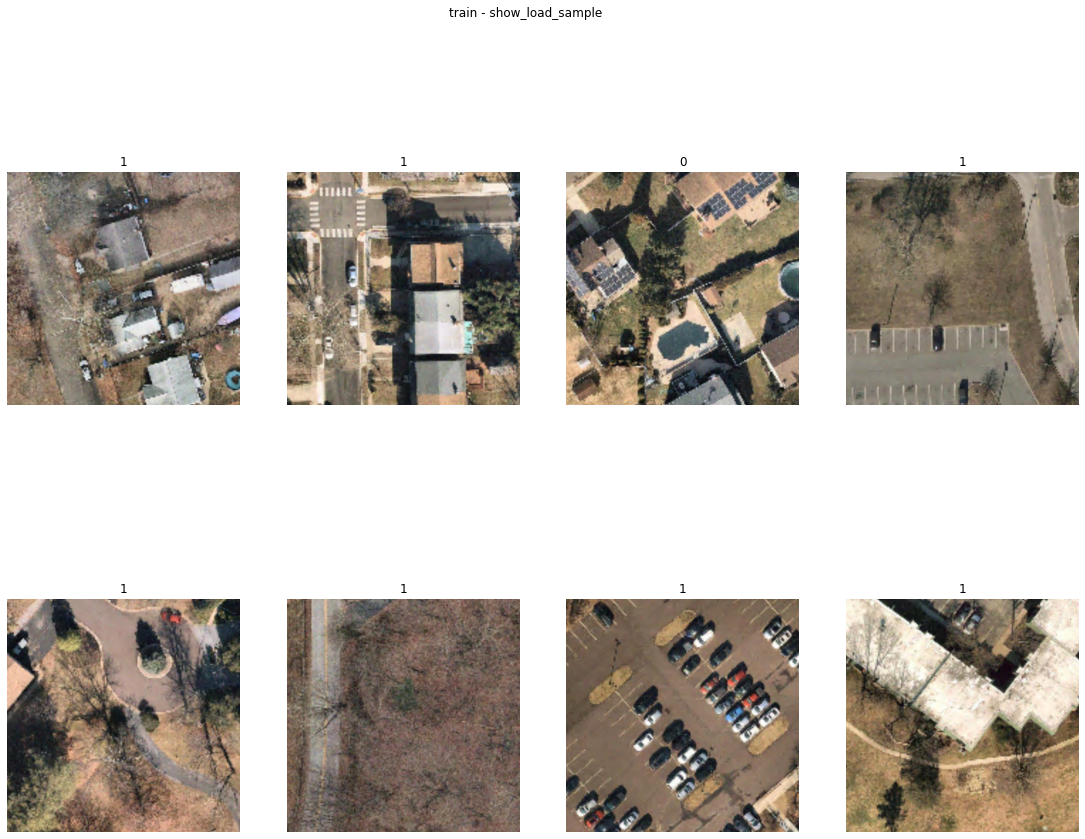

In [85]:
datamodule.show_train_batch(figsize=(19.2, 14.4))

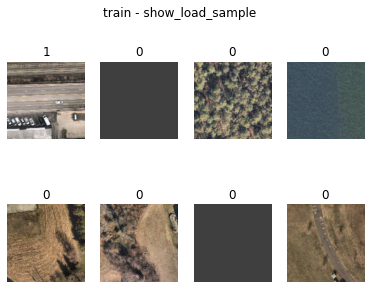

In [34]:
datamodule.show_train_batch() # old

In [92]:
print(pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/drive_combined.csv").has_road.value_counts())
weights, weight_per_class = pd_make_weights_for_balanced_classes("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/drive_combined.csv")
weights = torch.DoubleTensor(weights)
print(weights[:8])
print(weight_per_class)

no     1033
yes     472
Name: has_road, dtype: int64
tensor([1.4569, 3.1886, 1.4569, 3.1886, 1.4569, 3.1886, 3.1886, 3.1886],
       dtype=torch.float64)
no     1.456922
yes    3.188559
Name: has_road, dtype: float64


In [102]:
# 1. Prep the data
drive_dm = ImageClassificationData.from_csv(
    "image",
    "has_road",
    train_file="/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/drive_combined.csv",
    target_formatter=flash.core.data.utilities.classification.SingleLabelTargetFormatter(labels=["no", "yes"]),
    transform=ImageClassificationInputTransform(),
    transform_kwargs={"image_size": (500, 500)},
    sampler=torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True),
    batch_size=8,
    num_workers=4
)

/deep/group/aicc-bootcamp/packages/miniconda3/envs/transportation/lib/python3.9/site-packages/pytorch_lightning/utilities/apply_func.py:31: LightningDeprecationWarning: `pytorch_lightning.utilities.apply_func.apply_to_collection` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_utilities.core.apply_func.apply_to_collection` instead.
  rank_zero_deprecation(


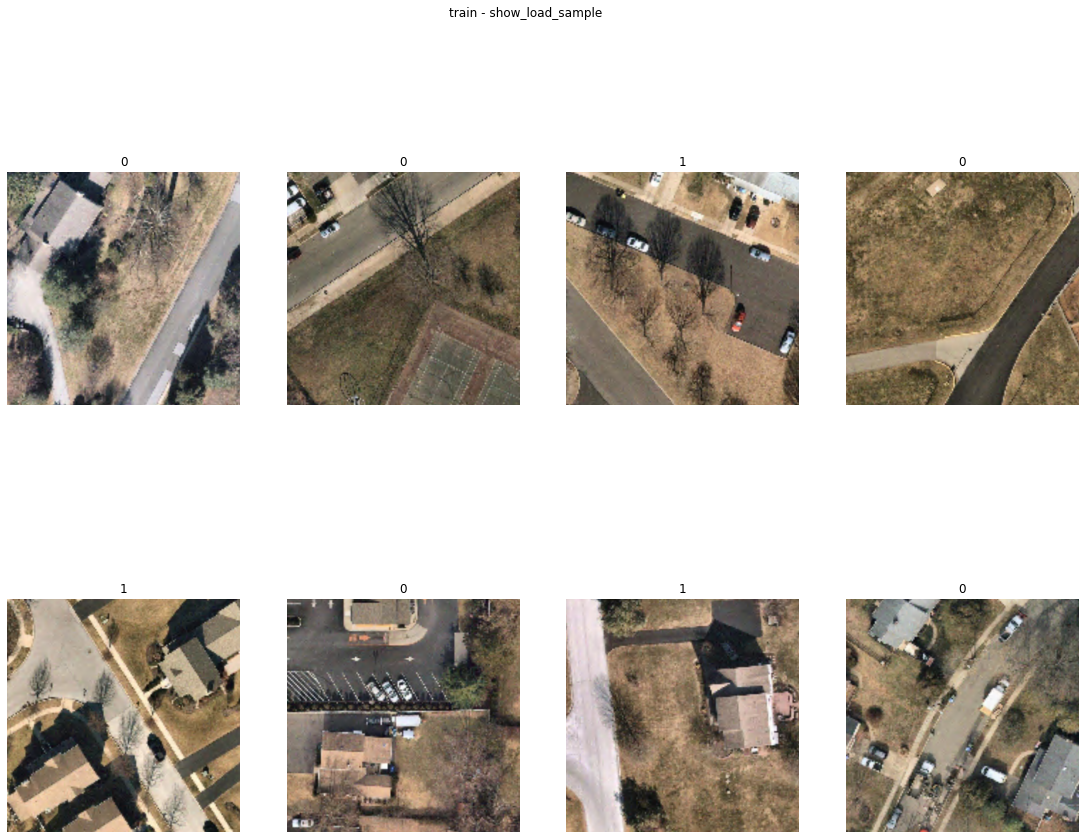

In [95]:
drive_dm.show_train_batch(figsize=(19.2, 14.4))

In [ ]:
from PIL import Image
with Image.open("/deep/group/aicc-bootcamp/transportation/data/dvrpc/aerial/imagery/500:0:0.1:18:-796:88651.png") as im:
    aug = T.RandAugment()
    rgb = im.convert('RGB')
    augd = aug(rgb)

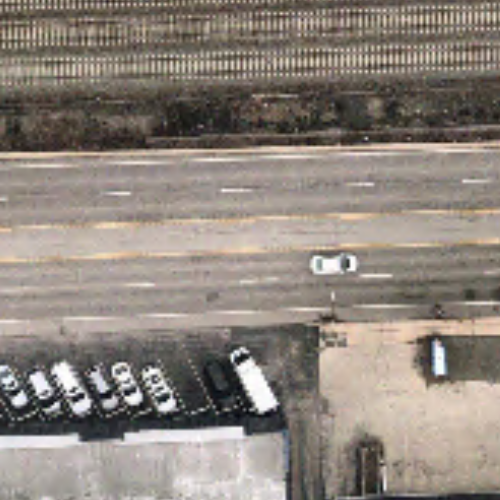

In [126]:
rgb

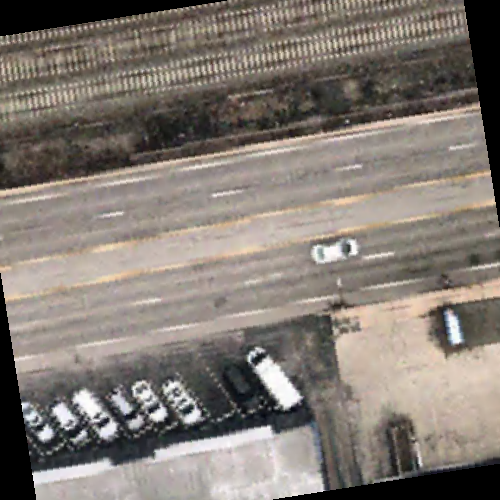

In [125]:
augd

In [129]:
# 1. Prep the data
drive_service_dm = ImageClassificationData.from_csv(
    "image",
    "has_road",
    train_file="/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/drive_service_combined.csv",
    target_formatter=flash.core.data.utilities.classification.SingleLabelTargetFormatter(labels=["no", "yes"]),
    transform=ImageClassificationInputTransform(),
    transform_kwargs={"image_size": (500, 500)},
    sampler=torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True),
    batch_size=8,
    num_workers=4
)

/deep/group/aicc-bootcamp/packages/miniconda3/envs/transportation/lib/python3.9/site-packages/pytorch_lightning/utilities/apply_func.py:31: LightningDeprecationWarning: `pytorch_lightning.utilities.apply_func.apply_to_collection` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_utilities.core.apply_func.apply_to_collection` instead.
  rank_zero_deprecation(


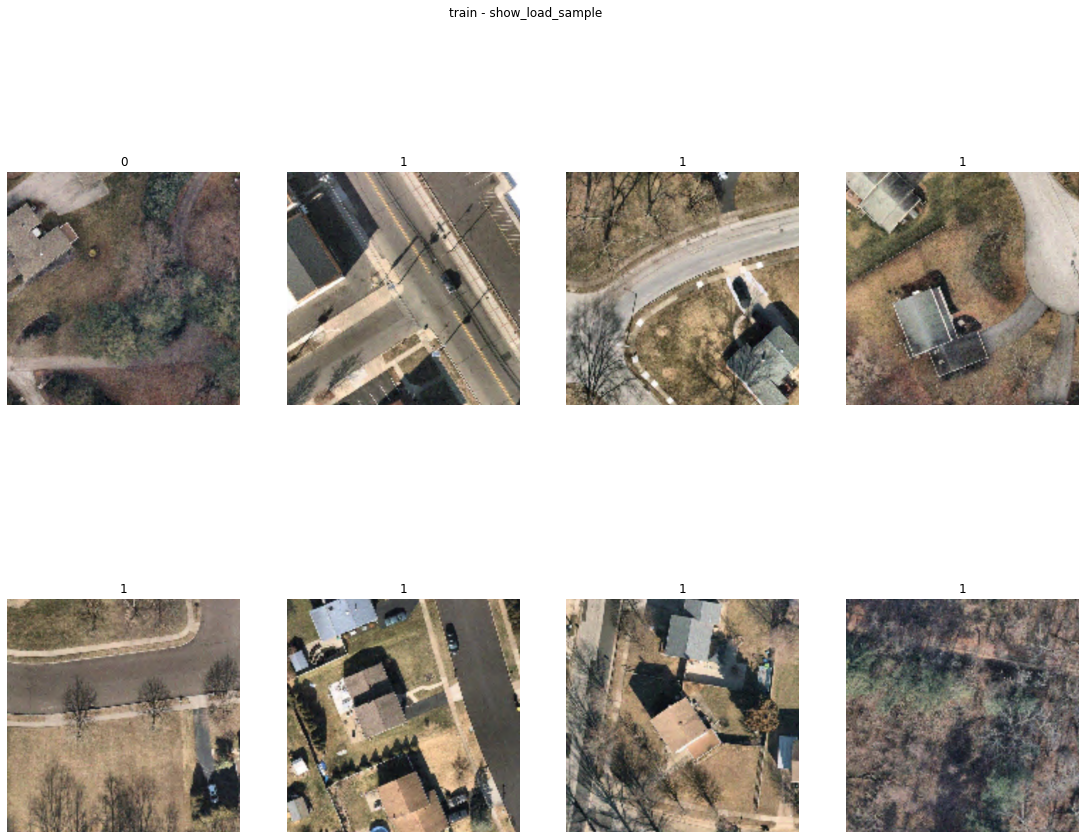

In [134]:
drive_service_dm.show_train_batch(figsize=(19.2, 14.4))

In [5]:
print(pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_combined.csv").has_road.value_counts())
weights, weight_per_class = pd_make_weights_for_balanced_classes("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_combined.csv")
weights = torch.DoubleTensor(weights)
print(weights[:8])
print(weight_per_class)

yes    1424
no       81
Name: has_road, dtype: int64
tensor([18.5802, 18.5802, 18.5802, 18.5802, 18.5802, 18.5802, 18.5802, 18.5802],
       dtype=torch.float64)
yes     1.056882
no     18.580247
Name: has_road, dtype: float64


In [9]:
# 1. Prep the data
all_drive_dm = ImageClassificationData.from_csv(
    "image",
    "has_road",
    train_file="/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_combined.csv",
    target_formatter=flash.core.data.utilities.classification.SingleLabelTargetFormatter(labels=["no", "yes"]),
    transform=ImageClassificationInputTransform(),
    transform_kwargs={"image_size": (500, 500)},
    sampler=torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True),
    batch_size=8,
    num_workers=4
)

/deep/group/aicc-bootcamp/packages/miniconda3/envs/transportation/lib/python3.9/site-packages/pytorch_lightning/utilities/apply_func.py:31: LightningDeprecationWarning: `pytorch_lightning.utilities.apply_func.apply_to_collection` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_utilities.core.apply_func.apply_to_collection` instead.
  rank_zero_deprecation(


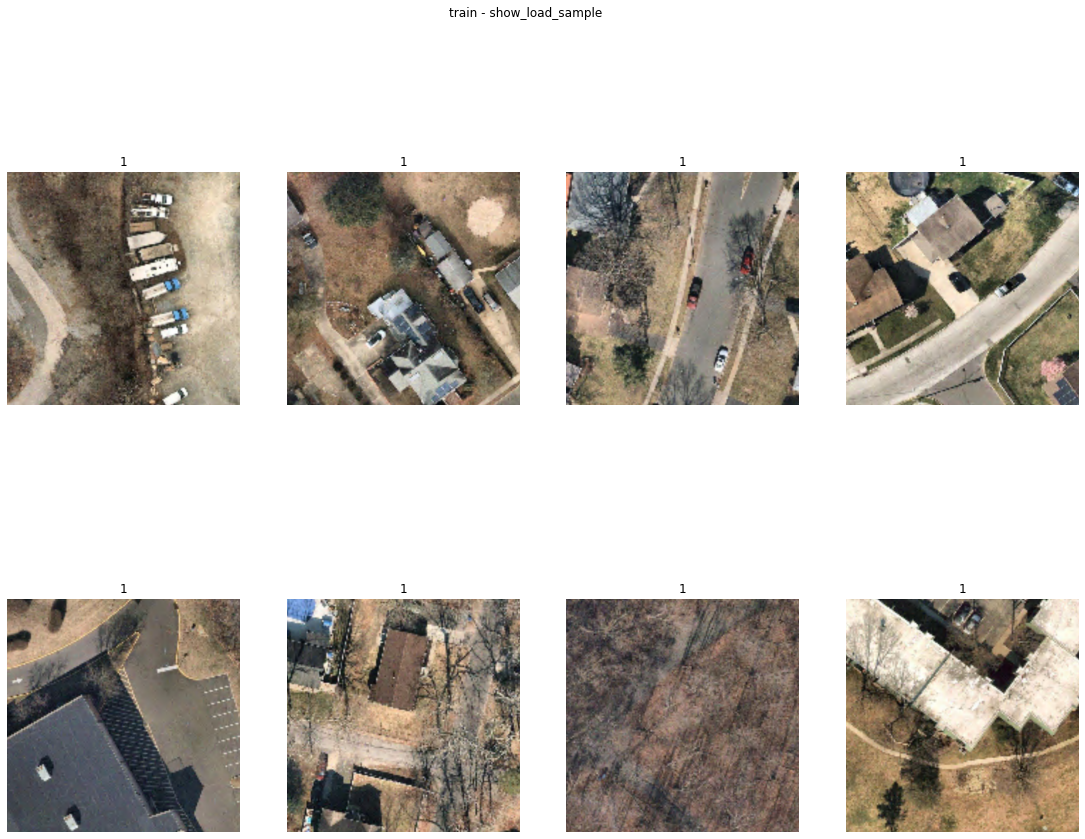

In [16]:
all_drive_dm.show_train_batch(figsize=(19.2, 14.4))

In [17]:
all_drive_df = pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_combined.csv")
drive_service_df = pd.read_csv("/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/drive_service_combined.csv")

In [21]:
df = pd.merge(all_drive_df, drive_service_df, on="image")
df = df.drop(columns=[df.columns[0], df.columns[3]])
df.head()

image has_road_x has_road_y
0  /deep/group/aicc-bootcamp/transportation/data/...        yes        yes
1  /deep/group/aicc-bootcamp/transportation/data/...        yes        yes
2  /deep/group/aicc-bootcamp/transportation/data/...        yes        yes
3  /deep/group/aicc-bootcamp/transportation/data/...        yes        yes
4  /deep/group/aicc-bootcamp/transportation/data/...        yes        yes

In [23]:
df[df["has_road_x"] == "yes"][df["has_road_y"] == "no"]

/tmp/ayushsn/ipykernel_2395351/4265811806.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["has_road_x"] == "yes"][df["has_road_y"] == "no"]


image has_road_x has_road_y
14    /deep/group/aicc-bootcamp/transportation/data/...        yes         no
17    /deep/group/aicc-bootcamp/transportation/data/...        yes         no
24    /deep/group/aicc-bootcamp/transportation/data/...        yes         no
25    /deep/group/aicc-bootcamp/transportation/data/...        yes         no
33    /deep/group/aicc-bootcamp/transportation/data/...        yes         no
...                                                 ...        ...        ...
1490  /deep/group/aicc-bootcamp/transportation/data/...        yes         no
1495  /deep/group/aicc-bootcamp/transportation/data/...        yes         no
1496  /deep/group/aicc-bootcamp/transportation/data/...        yes         no
1501  /deep/group/aicc-bootcamp/transportation/data/...        yes         no
1502  /deep/group/aicc-bootcamp/transportation/data/...        yes         no

[378 rows x 3 columns]

In [31]:
diff_df = df[df["has_road_x"] == "yes"][df["has_road_y"] == "no"]

/tmp/ayushsn/ipykernel_2395351/1190268131.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diff_df = df[df["has_road_x"] == "yes"][df["has_road_y"] == "no"]


In [25]:
diff_df = df[df["has_road_x"] == "yes"][df["has_road_y"] == "no"]
diff_df.to_csv('/deep/u/ayushsn/satellite-pixel-synthesis-pytorch/preprocess/all_drive_service_diff.csv')

/tmp/ayushsn/ipykernel_2395351/3228901096.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diff_df = df[df["has_road_x"] == "yes"][df["has_road_y"] == "no"]


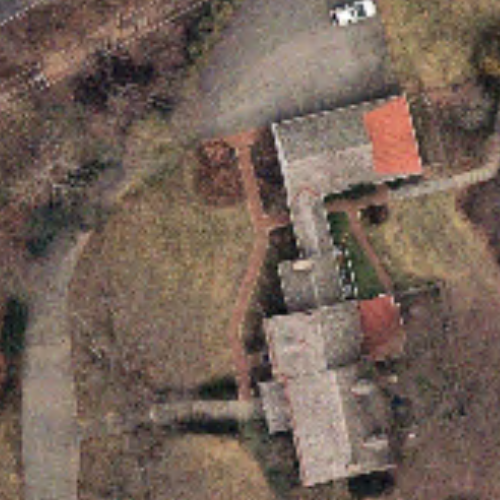

In [42]:
from IPython.display import display
from IPython.display import Image as IPImage
diff_df = diff_df.reset_index(drop=True)
display(IPImage(diff_df["image"][9]))